<a href="https://colab.research.google.com/github/FranciscoHernandez1998/lab3-SP1-17004812/blob/master/Lab_3_Clasificador_de_texto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Clasificador de reviews de peliculas en Positiva o negativa
#Clasificacion binaria o de dos clases, 
#Transfer learning con keras
#Dataset de imdb con 50,000 reviews, 25,000 para training y 25,000 para testing
#Mismo numero de reviews positivas y negativas
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import tensorflow as tf

!pip install -q tensorflow-hub
!pip install -q tfds-nightly
import tensorflow_hub as hub
import tensorflow_datasets as tfds

#imdb dataset
#Set dividido en 60% y 40%, 15,000 para training, 10,000 para validacion y 25,000 para testing
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)


TensorFlow 2.x selected.


In [2]:
#el formato de los datos es, la oracion que describe a la pelicula, y una etiqueta
#correspondiente a 0 o 1, Los primeros 10 ejemplos son
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
train_examples_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell 

In [3]:
#Las primeras 10 labels son
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])>

In [4]:
#La red neural se crea con un stack de capas, existen tres decisiones importantes

#Como representar el texto ?
#Cuantas capas utilizar para el modelo ?
#Cuantas unidades usar para cada capa ?

#Una forma comunmente utilizada es la representacion de oraciones como "Embedding vectors"
#Es decir vincular las palabras o frases a vectores, y esto nos proporciona 3 ventajas

#Ya no nos preocuparemos del preprocesamiento de texto
#Nos beneficiamos con transfer learning
#Los vectores tienen un tamaño fijo, por lo que es mas sencillo de procesar

#El modelo de encapsulacion de texto previamente entrenado a utilizar  para 
#tensorflow/hub (libreria para transfer learning para reutilizar partes de modelos de TF)
#es "google/tf2-preview/gnews-swivel-20dim/1"

#Creando la capa Keras que usa el modelo de TensorFlow Hub para encapsular las oraciones:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

#test con un input:
hub_layer(train_examples_batch[:3])
#Sin importar el tamaño de la oracion de entrada, la salida tiene la forma:
#(num_examples, embedding_dimension)


<tf.Tensor: shape=(3, 20), dtype=float32, numpy=
array([[ 1.765786  , -3.882232  ,  3.9134233 , -1.5557289 , -3.3362343 ,
        -1.7357955 , -1.9954445 ,  1.2989551 ,  5.081598  , -1.1041286 ,
        -2.0503852 , -0.72675157, -0.65675956,  0.24436149, -3.7208383 ,
         2.0954835 ,  2.2969332 , -2.0689783 , -2.9489717 , -1.1315987 ],
       [ 1.8804485 , -2.5852382 ,  3.4066997 ,  1.0982676 , -4.056685  ,
        -4.891284  , -2.785554  ,  1.3874227 ,  3.8476458 , -0.9256538 ,
        -1.896706  ,  1.2113281 ,  0.11474707,  0.76209456, -4.8791065 ,
         2.906149  ,  4.7087674 , -2.3652055 , -3.5015898 , -1.6390051 ],
       [ 0.71152234, -0.6353217 ,  1.7385626 , -1.1168286 , -0.5451594 ,
        -1.1808156 ,  0.09504455,  1.4653089 ,  0.66059524,  0.79308075,
        -2.2268345 ,  0.07446612, -1.4075904 , -0.70645386, -1.907037  ,
         1.4419787 ,  1.9551861 , -0.42660055, -2.8022065 ,  0.43727064]],
      dtype=float32)>

In [5]:
#Construyendo el modelo para la red neural

#Primera capa: Modelo pre-entrenado de TF Hub, que mapea una oracion a un "embedding vector"
#en este caso el modelo es google/tf2-preview/gnews-swivel-20dim/1, que particiona la oracion en tokens
#los encapsula y los une, las dimensiones resultantes son: (num_examples, embedding_dimension)

#Posteriormente el vector pasa por una capa totalmente conectada(Dense) con 16 neuronas

#La ultima capa esta conectada con un solo nodo output, el cual usa la funcion de activacion
#Sigmoid, y devuelve un float entre 0 y 1 para representar una probabilidad o nivel de confianza
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


In [0]:
#La funcion Loss a utilizar sera binary_crossentropy , debido a que es un clasificador binario
#y el modelo nos devuelve una probabilidad. binary_crossentropy es el que mejor lidia con probabilidades.
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [7]:
#El modelo se entrenara por 20 epochs, en batches de 512 ejemplos. Estas son 20 iteraciones sobre
#todos los datos, en los tensores x_train y y_train. 
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=20,
                    validation_data=validation_data.batch(512),
                    verbose=1)


Epoch 1/20
30/30 [==============================] - 6s 201ms/step - loss: 0.9940 - accuracy: 0.4652 - val_loss: 0.8340 - val_accuracy: 0.4765
Epoch 2/20
30/30 [==============================] - 6s 189ms/step - loss: 0.7604 - accuracy: 0.4945 - val_loss: 0.7257 - val_accuracy: 0.5106
Epoch 3/20
30/30 [==============================] - 6s 194ms/step - loss: 0.6890 - accuracy: 0.5678 - val_loss: 0.6744 - val_accuracy: 0.5972
Epoch 4/20
30/30 [==============================] - 6s 192ms/step - loss: 0.6398 - accuracy: 0.6500 - val_loss: 0.6313 - val_accuracy: 0.6574
Epoch 5/20
30/30 [==============================] - 6s 185ms/step - loss: 0.6016 - accuracy: 0.6953 - val_loss: 0.5978 - val_accuracy: 0.7000
Epoch 6/20
30/30 [==============================] - 6s 196ms/step - loss: 0.5647 - accuracy: 0.7288 - val_loss: 0.5618 - val_accuracy: 0.7280
Epoch 7/20
30/30 [==============================] - 6s 198ms/step - loss: 0.5249 - accuracy: 0.7587 - val_loss: 0.5227 - val_accuracy: 0.7574
Epoch 

In [8]:
#Podemos evluar el modelo y su rendimiento, el sig. fragmento retornara los valores de Loss
#que representa nuestroe error, y Accuracy
results = model.evaluate(test_data.batch(512), verbose=2)
for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

loss: 0.324
accuracy: 0.862


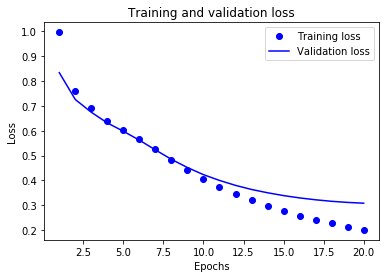

In [9]:
history_dict = history.history
history_dict.keys()

import matplotlib.pyplot as plt
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)
# "bo" es por "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b es para "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


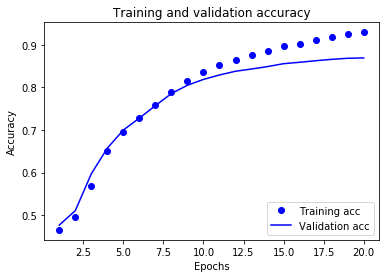

In [10]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

#En la grafica los puntos representan a "training loss and accuracy" y las lineas
#solidas a "validation loss and accuracy". se observa que "training loss" disminuye 
#con cada epoch, mientras que "Training accuracy" incrementa. Esto se espera con gradient descent
#que cada cantidad se minimice tras cada iteracion. 

#"Validation loss and accuracy" vemos que incrementa mucho luego de 20 epochs, por lo que
#sucede overfitting. El modelo predice mejor sobre "training data" que sobre datos que no ha analizado antes
#en este punto el modelo aprende de representaciones especificas. Esto se previene deteniendolo con 20 epochs.
